In [21]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [159]:
from __future__ import print_function
%matplotlib inline
import os
import torch
import numpy as np
import sys
from dev.otu_handler import OTUHandler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from dev.models.rnn.conv_lstm import *
from dev.models.rnn.lstm import *
from dev.models.enc_dec.encoder_decoder import *
from dev.models.enc_dec_vae.variational_encoder_decoder import *
from dev.models.ffn.ffn import *
from dev.models.ffn.conv_ffn import *
from helpers.model_helper import *
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from matplotlib.cm import ScalarMappable
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [3]:
# Some helper functions.

def get_primer_and_comparison_data(otu_handler,
                                   sample_index,
                                   start_index,
                                   primer_len,
                                   predict_len):
    primer = otu_handler.samples[sample_index].values[:, start_index: start_index + primer_len]
    # Need to make it 3d because the last dimension is how many predictions to do at once. 
    primer = np.expand_dims(primer, -1)
    # Get the comparison data.
    comparison = otu_handler.samples[sample_index].values[:, start_index:predict_len + start_index + primer_len]
    return primer, comparison

def complete_and_multiindex_df(df, split_char):
    default_tax = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    s = list(df.index.values)
    lt = [list(ls.split(split_char)) for ls in s]
    lt = [[ltii.strip() for ltii in lti] for lti in lt]
    for l in lt:
        if len(l) < len(default_tax):
            l += default_tax[-(len(default_tax)-len(l)):]

    ltn = pd.DataFrame(np.array(lt))
    ltn.index = df.index
    ltn.columns = default_tax
    combined = pd.concat((df, ltn), axis=1)
    combined.set_index(default_tax, inplace=True)
    return combined

In [4]:
# Here we instantiate the data handler.
# What data to load to the data handler.
parent = 'input_data/summed_completed_no_chloro/'
input_dir = 'all_strains_top_N/'
# test_dir = 'test'
# input_dir = 'train_completed_normalized_sub_31/'
# test_dir = 'test_completed_normalized_sub_31/'

input_dir = os.path.join(parent, input_dir)
# test_dir = os.path.join(parent, test_dir)

In [5]:
# Instantiate an OTU Handler.

input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
# test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

# Uncomment this if you want to include the test data in the plots:
# input_files += test_files
input_files.sort()
print('\n'.join(input_files))
otu_handler = OTUHandler(input_files)
otu_handler.normalize_data('clr')
otu_handler.normalize_data('zscore')

input_data/summed_completed_no_chloro/all_strains_top_N/1015-reference-hit_metadata_1015:F01_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv
input_data/summed_completed_no_chloro/all_strains_top_N/1015-reference-hit_metadata_1015:M01_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv
input_data/summed_completed_no_chloro/all_strains_top_N/1015-reference-hit_metadata_1015:M02_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv
input_data/summed_completed_no_chloro/all_strains_top_N/10283_combined_biom_LS_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv
input_data/summed_completed_no_chloro/all_strains_top_N/11052_combined_biom_F04_stool_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv
input_data/summed_completed_no_chloro/all_strains_top_N/11052_combined_biom_F20_stool_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv
input_data/summed_completed_no_chloro/all_strains_top_N/11052_combined_biom_M03_stool_

In [6]:
# Now we generate a grouping and coloring for the strains

# How many taxonomy levels to include in the plots. 
# Higher numbers results in a a larger number of strains, ie less grouping
levels = 4
join_char = '\n'
split_char = ';'
# Reindex the dataframes
multi_samples = [complete_and_multiindex_df(s, split_char) for s in otu_handler.samples]


# Get various pieces of data about the taxonomy.
grouped = [ms.groupby(level=list(range(0, levels))) for ms in multi_samples]
# Taxonomy names
labels = [join_char.join(c) for c in grouped[0].count().index]

labs = [join_char.join(c[0:levels]) for c in multi_samples[0].index.values]
full_labs = [join_char.join(c.split(split_char)) for c in otu_handler.samples[0].index.values]

unique_ints = list(range(len(labels)))
unique_int_lookup = dict(zip(labels, unique_ints))
labs_to_ints = [unique_int_lookup[l] for l in labs]
print('There are {} distinct groups'.format(len(labels)))

num_colors = len(list(set(labs)))
cmap = plt.cm.get_cmap('tab20', num_colors)
colors = cmap(np.linspace(0, 1, num_colors))
color_lookup = dict(zip(labels, colors))
colors_to_plot = [color_lookup[l] for l in labs]

There are 8 distinct groups


In [7]:
print(len(colors_to_plot))

36


In [8]:
# This is just a nice label for the plotting
file_labs = ['Donor$_{}$'.format(i) for i in range(len(input_files))]

In [9]:
# Put the model type in here
model_type = 'enc_dec'
# What is the name of the model and logs outputted?
run_suffix = '_EncDec_h512_isl5_tsl5_ns36_isifNone_tsif2_numlstm1_no_chloro'

In [10]:


model_lookup = {
    'enc_dec': EncoderDecoder,
    'lstm': LSTM,
    'conv_lstm': ConvLSTM,
    'ffn': FFN,
    'conv_ffn': ConvFFN,
    'vae': VariatonalEncoderDecoder
}

model_outputs = {
    'enc_dec': '2019_enc_dec_output/',
    'lstm': 'rnn_output/',
    'ffn': 'ffn_output',
    'conv_ffn': 'ffn_output',
    'conv_lstm': 'rnn_output',
    'vae': 'VAE_output'
}

In [11]:
model_name = 'model{}.pt'.format(run_suffix)
log_name = 'log{}.npy'.format(run_suffix)
output_dir = model_outputs[model_type]


# Plot the Training Loss

In [12]:
losses = np.load(os.path.join(output_dir, log_name))
print(losses.shape)

(3, 36, 51)


(0, 1)

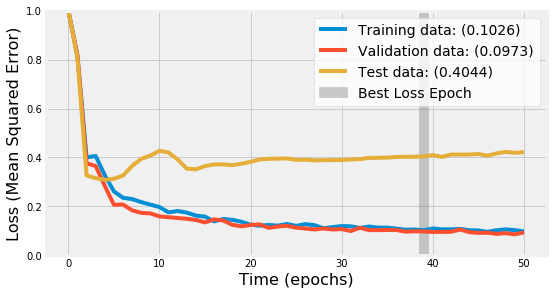

In [13]:
loss_num_digits = 6
best_loss_epoch = 39

fig, ax = plt.subplots(figsize=(8, 4.5))
labels = ['Training data: ({})', 'Validation data: ({})', 'Test data: ({})']

for i in range(losses.shape[0]):
    plt.plot(losses[i, ...].sum(axis=0).T, label=labels[i].format(str(losses[i, :, best_loss_epoch].sum())[:loss_num_digits]))
ax.axvspan(best_loss_epoch - 0.5, best_loss_epoch + 0.5, alpha=0.4, color='gray', label='Best Loss Epoch')
legend = plt.legend(frameon = 1, loc='upper right', fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.xlabel('Time (epochs)', fontsize=16)
plt.ylabel('Loss (Mean Squared Error)', fontsize=16)
plt.ylim(0, 1)
# plt.title('Loss Over Training', fontsize=18)


# Loss per strain
These are the data collected over the training course. 

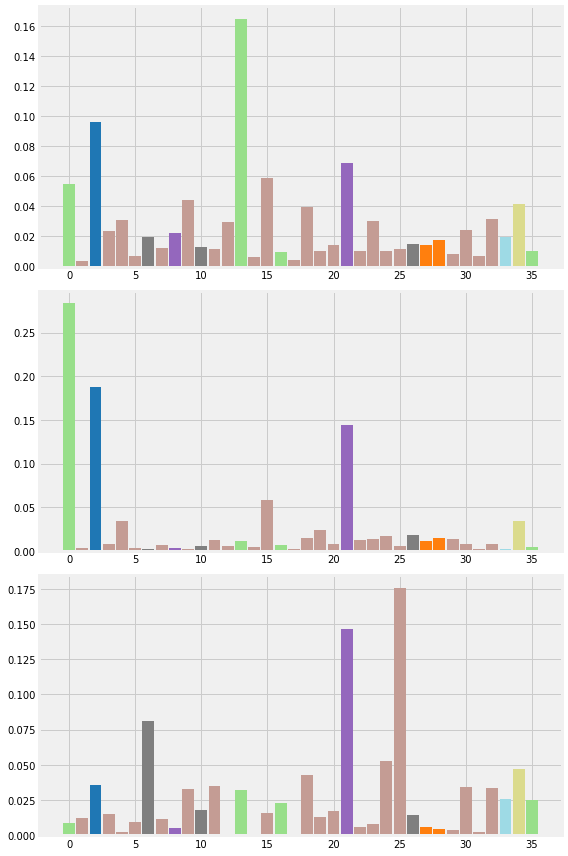

In [14]:
loss_labels = ['Training Data', 'Validation Data', 'Test Data']
bar_width = 0.9
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharey=False)
axl = ax.flatten()
for i in range(losses.shape[0]):
    rects1 = axl[i].bar(range(losses.shape[1]), 
                        losses[i, :, best_loss_epoch] / (losses[i, :, best_loss_epoch].sum()), 
                        bar_width, color=colors_to_plot)
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    axl[i].set_xticks(list(range(losses.shape[1]))[::5])
#     axl[i].set_title(loss_labels[i], fontsize=14, style='italic', y=0.99)
    plt.tight_layout()
# plt.suptitle('Normalized Loss Contribution from Each Strain', y=1.015, fontsize=24)

# Loss per strain per donor
These data are generated by making new predictions with the loaded model.

## Load the model

In [25]:
ls input_data/summed_completed_no_chloro/test

1015-reference-hit_metadata_1015:M01_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv


In [36]:
input_dir = 'input_data/summed_completed_no_chloro/train/'
test_dir = 'input_data/summed_completed_no_chloro/test/'

input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

otu_handler2 = OTUHandler(input_files, test_files=test_files)
otu_handler2.normalize_data('clr')
otu_handler2.normalize_data('zscore')
otu_handler2.set_train_val()
otu_handler2.min_len = 30

Skipping file, 0, because it's of shape: (36, 68)
Skipping file, 1, because it's of shape: (36, 48)
Skipping file, 2, because it's of shape: (36, 145)
Skipping file, 7, because it's of shape: (36, 191)


In [28]:
# CUDA_LAUNCH_BLOCKING=1
torch.cuda.set_device(1)
# Instantiate the model
hidden_dim = 512
reduced_num_strains = 36
slice_len = 36
num_lstm = 1
use_gpu = torch.cuda.is_available()
otu_handler.min_len = 30
# print(model_name)
# Basically load the correct type of model. 
if model_type == 'enc_dec' or model_type.endswith('lstm') or model_type == 'vae':
    model = model_lookup[model_type](hidden_dim, otu_handler2, num_lstm, use_gpu, LSTM_in_size=reduced_num_strains)
else:
    model = model_lookup[model_type](hidden_dim, otu_handler2, slice_len, use_gpu)
print(model_name) 
print(model_lookup[model_type])
model.load_state_dict(torch.load(os.path.join(output_dir, model_name)))

model = model.cuda()

model_EncDec_h512_isl5_tsl5_ns36_isifNone_tsif2_numlstm1_no_chloro.pt
<class 'dev.models.enc_dec.encoder_decoder.EncoderDecoder'>


In [31]:
loss_function = nn.MSELoss()
model.batch_size = 50
test_index = 1

In [34]:
# Make labels for train and validation data.
train_labels = ['Donor$_{}$'.format(i) for i in range(len(otu_handler.samples)) if i != test_index]
val_labels = ['Donor$_{}$'.format(i) for i in range(len(otu_handler.samples)) if i not in [0, 1, 2, 7]]
test_labels = ['Donor$_{}$'.format(i) for i in range(len(otu_handler.samples)) if i == test_index]

In [74]:
# This runs a bunch of simulations through predicting on train, validation, and test data. 
input_length = 5
target_length = 30
teacher_force_frac = 0.5
num_batches = 2
t_v_t_losses = []
num_samples = 15
data_lists = [model.otu_handler.train_data, model.otu_handler.val_data, model.otu_handler.test_data]
data_sources = ['train', 'validation', 'test']

# Which data train, val, test
for k, data_source in enumerate(data_sources):
    # Iterate through the right list.
    for i in range(len(data_lists[k])):
        # Empty array
        all_losses_temp = np.zeros((1, model.otu_handler.num_strains, num_samples))
        # How many trials to conduct.
        for j in range(num_samples):    
            losses = model.get_intermediate_losses(loss_function,
                                                   input_length, target_length, teacher_force_frac,
                                                   which_donor=i,
                                                   which_sample=data_source,
                                                   num_batches=num_batches)
            # assign the losses
            losses /= losses.sum()
            all_losses_temp[:, :, j] = losses
        # Normalize the values.
#         all_losses_temp = all_losses_temp / all_losses_temp.sum()
        if i == 0:
            all_losses = all_losses_temp
        else:
            all_losses = np.concatenate((all_losses, all_losses_temp), axis=0)
    print(all_losses.shape)
    t_v_t_losses.append(all_losses)

(8, 36, 15)
(4, 36, 15)
(1, 36, 15)


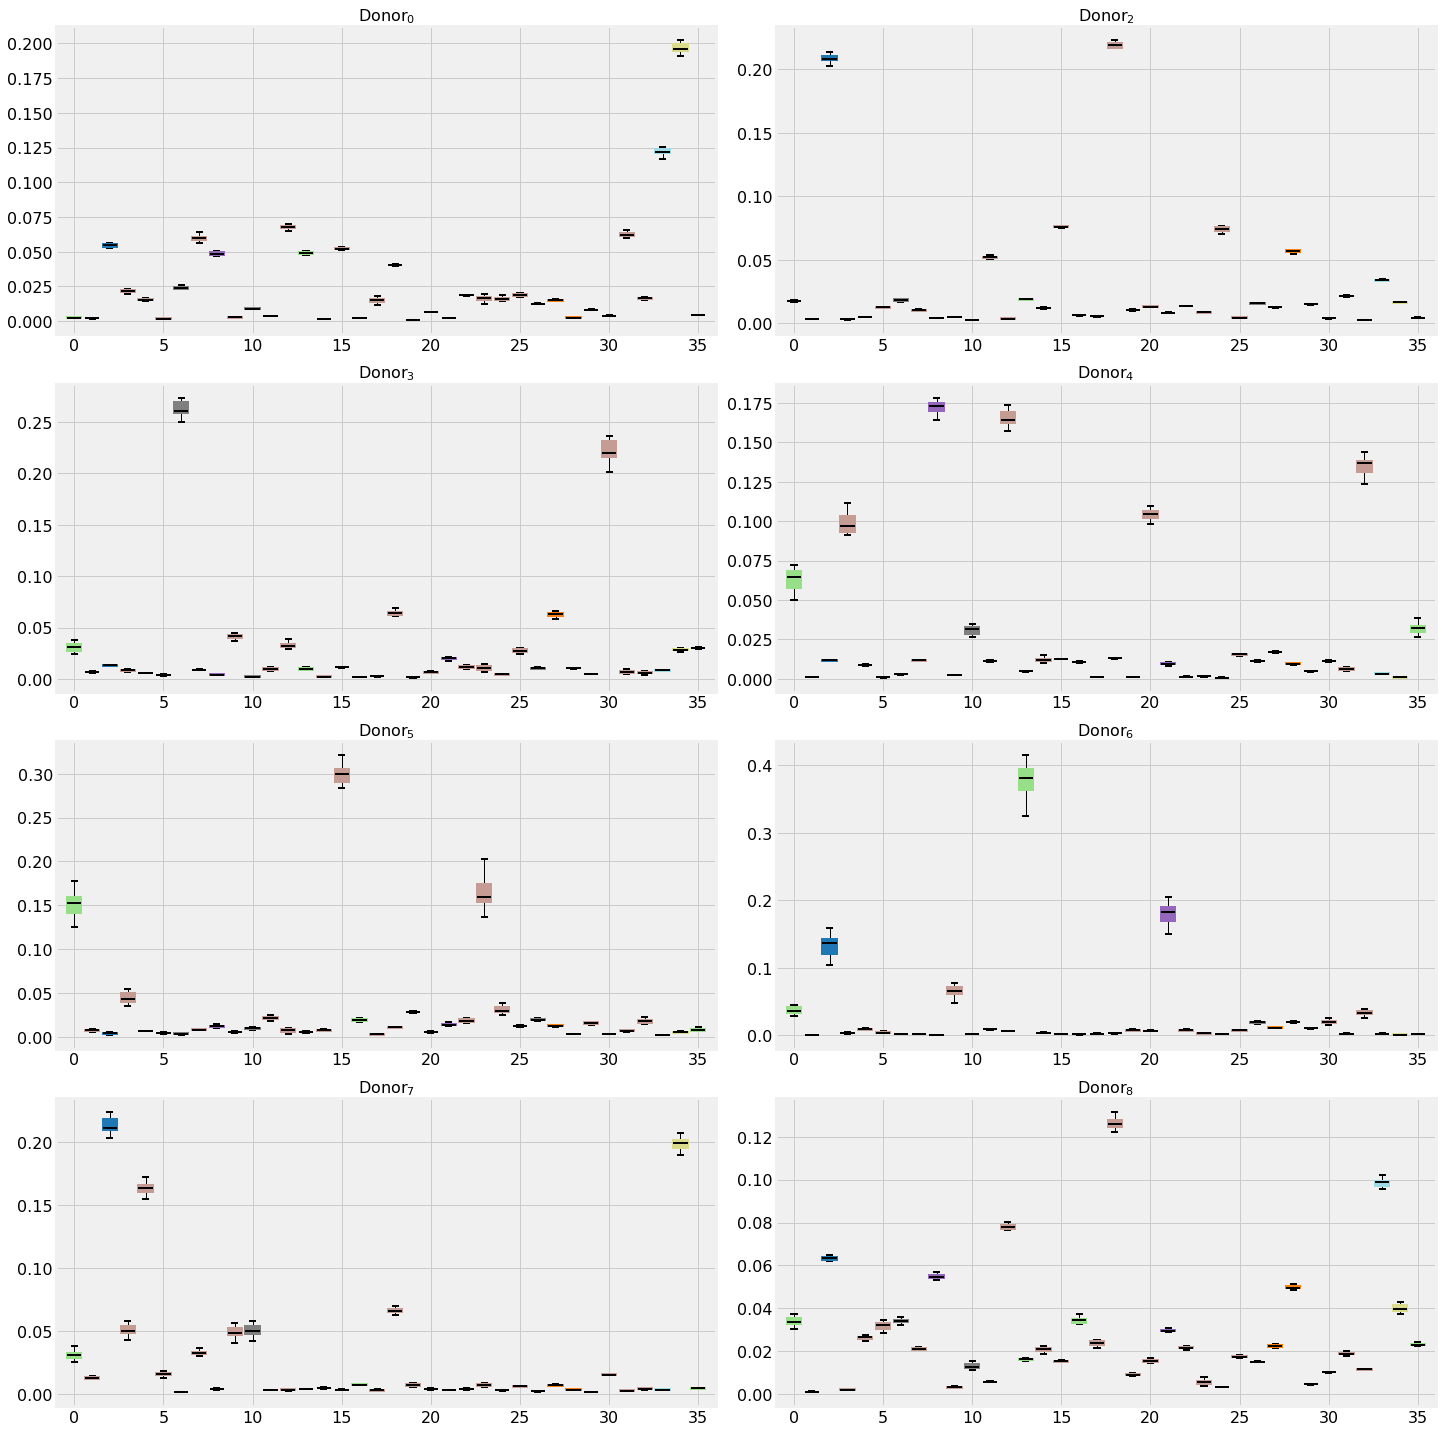

In [94]:
# Plot the training data.
fig, ax = plt.subplots(4,2, figsize=(20, 20))
axl = ax.flatten()
# train_without_test = train[:1] + train[2:]

for i in range(t_v_t_losses[0].shape[0]):
    to_plot = t_v_t_losses[0][i].tolist()
    bp = axl[i].boxplot(to_plot, widths=[0.8] * otu_handler.num_strains, patch_artist=True, showfliers=False)
    axl[i].set_xticks(list(range(1, otu_handler.num_strains + 2))[::5])
    axl[i].set_xticklabels(list(range(otu_handler.num_strains + 1))[::5], fontsize=16)
    axl[i].set_xlim(0, otu_handler.num_strains + 1)
    axl[i].tick_params(axis='both', labelsize=16)

    for j, box in enumerate(bp['boxes']):
        # change outline color
        box.set(linewidth=2)
        # change fill color
        box.set(facecolor=colors_to_plot[j], color=colors_to_plot[j])

    # change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='black', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='gray', alpha=0.5)
    axl[i].set_title(train_labels[i], fontsize=16)
          
plt.tight_layout()
plt.show()

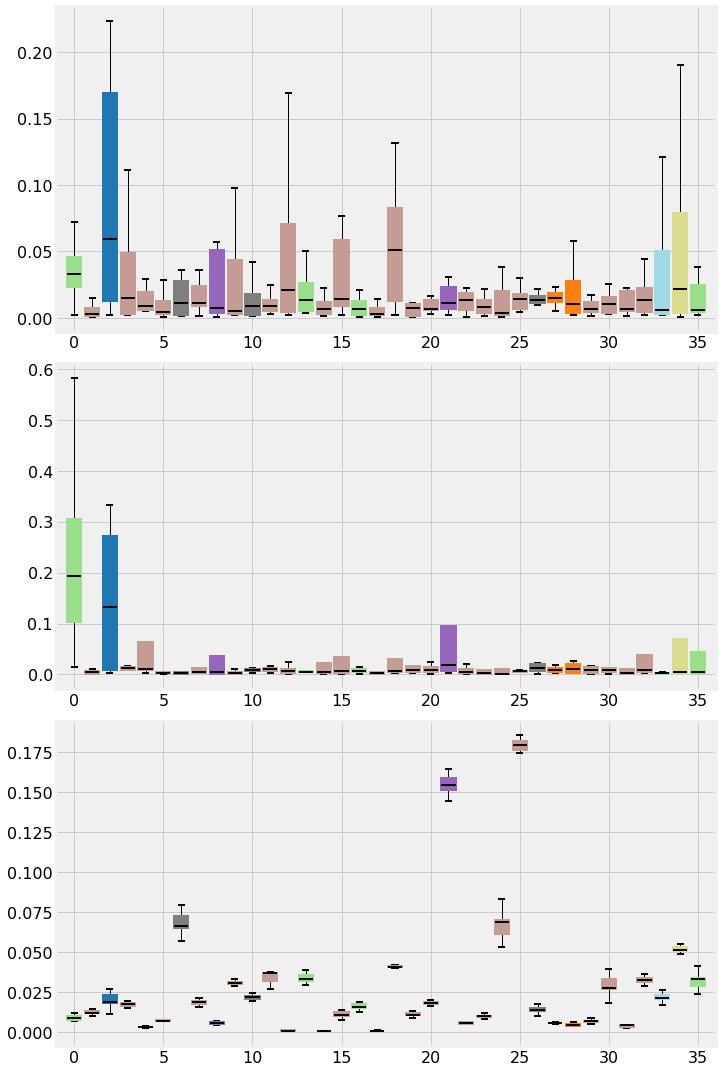

In [87]:
# Plot train, validation, and test data.
train_list = t_v_t_losses[0].transpose(1, 0, 2).reshape(model.otu_handler.num_strains, -1).tolist()
val_list = t_v_t_losses[1].transpose(1, 0, 2).reshape(model.otu_handler.num_strains, -1).tolist()
test_list = t_v_t_losses[2].transpose(1, 0, 2).reshape(model.otu_handler.num_strains, -1).tolist()
fig, ax = plt.subplots(3,1, figsize=(10, 15))
axl = ax.flatten()

for i, to_plot in enumerate([train_list, val_list, test_list]):
#     to_plot = t_v_t_losses[0][i].tolist()
    bp = axl[i].boxplot(to_plot, widths=[0.8] * otu_handler.num_strains, patch_artist=True, showfliers=False)
    axl[i].set_xticks(list(range(1, otu_handler.num_strains + 2))[::5])
    axl[i].set_xticklabels(list(range(otu_handler.num_strains + 1))[::5], fontsize=16)
    axl[i].set_xlim(0, otu_handler.num_strains + 1)
    axl[i].tick_params(axis='both', labelsize=16)
    for j, box in enumerate(bp['boxes']):
        # change outline color
        box.set(linewidth=2)
        # change fill color
        box.set(facecolor=colors_to_plot[j], color=colors_to_plot[j])
    # change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='black', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='gray', alpha=0.5)
          
plt.tight_layout()
plt.show()

/opt/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


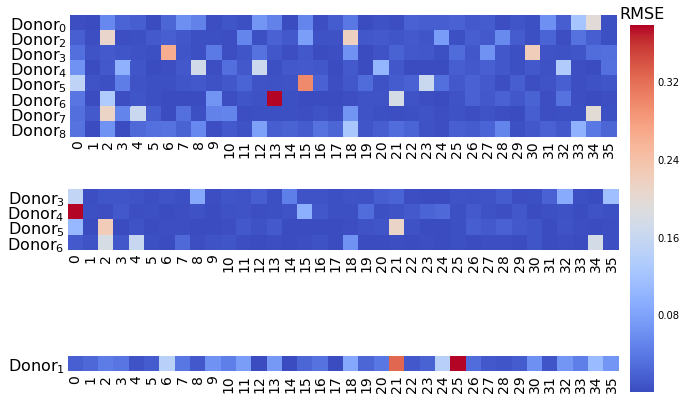

In [131]:
train = t_v_t_losses[0].transpose(1, 0, 2).mean(axis=2)
val = t_v_t_losses[1].transpose(1, 0, 2).mean(axis=2)
test = t_v_t_losses[2].transpose(1, 0, 2).mean(axis=2)


fig, ax = plt.subplots(3, 1, figsize=(11, 6))
axl = ax.flatten()
cbar_ax = fig.add_axes([0.8, 0.1, .03, 0.85])

donor_labels = [train_labels, val_labels, test_labels]
for i, to_plot in enumerate([train, val, test]):
    sns.heatmap(to_plot.T, square=True, cmap='coolwarm', ax=axl[i], cbar=i == 0,
               cbar_ax=None if i else cbar_ax)
    axl[i].set_xticklabels(list(range((to_plot.shape[0]))), fontsize=14, rotation=90)
    axl[i].set_yticklabels(donor_labels[i], fontsize=16, rotation=0)

cbar_ax.set_title("RMSE", fontsize=16)
fig.tight_layout(rect=[0, 0, 0.8, 1])

In [106]:
# Figure out which donors have the most outlying data.
percentiles = []
for i in range(train.shape[0]):
    percentiles.append(np.percentile(train[i], [25, 50, 75]))
percentiles = np.array(percentiles)

# Make a boolean of whether or not it's an outlier.
outliers = np.zeros(train.shape)
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        outliers[i, j] = (train[i, j] < percentiles[i, 0] or train[i, j] > percentiles[i, 2])
print(outliers.shape)

(36, 8)


(0, 36)

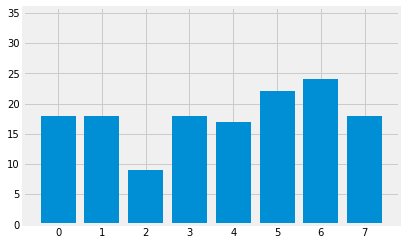

In [79]:
plt.bar(range(outliers.shape[1]), outliers.sum(axis=0))
plt.ylim(0, outliers.shape[0])

# Get the hardest strains to predict

In [129]:
sorted_indices = []
for i in range(len(t_v_t_losses)):
    temp_avg = t_v_t_losses[i].mean(axis=(0, 2))
    indices = list(range(len(temp_avg)))
    sorted_indices.append([x for _,x in sorted(zip(temp_avg, indices))])

how_many = 10
for i, name in enumerate(['Training', 'Validation', 'Test']):
    print('{} easiest to predict: {}'.format(name, sorted_indices[i][:how_many]))
    print('{} hardest to predict: {}'.format(name, sorted_indices[i][-how_many:][::-1]))
    print()

Training easiest to predict: [1, 17, 14, 29, 19, 5, 16, 22, 26, 35]
Training hardest to predict: [2, 18, 13, 34, 15, 0, 12, 6, 8, 30]

Validation easiest to predict: [33, 17, 6, 5, 9, 1, 25, 16, 30, 13]
Validation hardest to predict: [0, 2, 21, 34, 4, 35, 15, 32, 8, 18]

Test easiest to predict: [14, 17, 12, 4, 31, 28, 22, 27, 8, 29]
Test hardest to predict: [25, 21, 6, 24, 34, 18, 11, 13, 32, 35]



## Comparing difficulty to predict and node connectivity

In [183]:
connectivity = pd.read_csv('/Volumes/export/isn/mwiest/all_donors.csv')
avg_rmse = [t_v_t_losses[i].mean(axis=(0, 2)) for i in range(len(t_v_t_losses))]
avg_by_node = connectivity.groupby('source')['deg_node'].mean()

SpearmanrResult(correlation=-0.24339381293376988, pvalue=0.15259119147869254)
0.09145622141579039


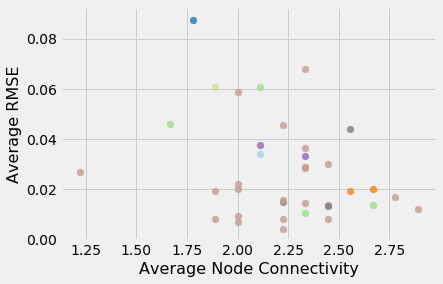

In [199]:
print(scipy.stats.spearmanr(avg_by_node, avg_rmse[0]))
r, pval = scipy.stats.pearsonr(avg_by_node, avg_rmse[0])
for i in range(len(avg_by_node)):
    plt.scatter(avg_by_node[i], avg_rmse[0][i], c=colors_to_plot[i], s=45, alpha=0.8)
#     plt.annotate(i, (avg_by_node[i], avg_rmse[0][i]), fontsize=8)
plt.xlabel('Average Node Connectivity', fontsize=16)
plt.ylabel('Average RMSE', fontsize=16)


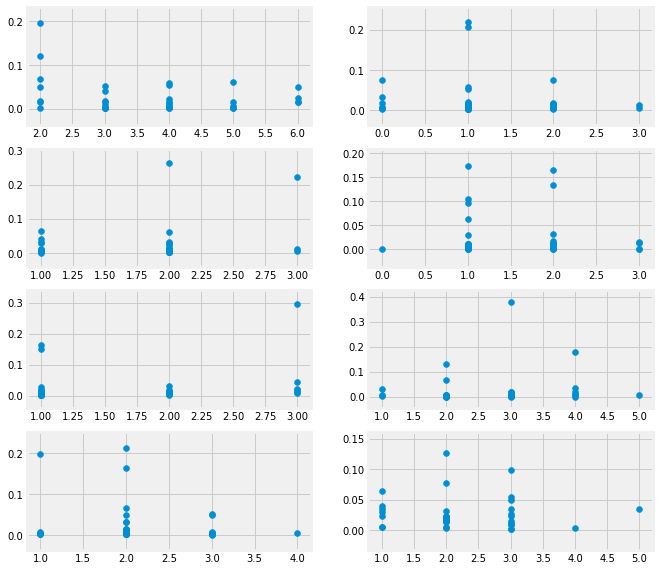

In [152]:
avg_rmse = [t_v_t_losses[i].mean(axis=(0, 2)) for i in range(len(t_v_t_losses))]

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
axl = ax.flatten()
for i in range(avg_rmse[0].shape[0]):
    node_score = connectivity[connectivity.donor == i].deg_node.values
    rmse_score = avg_rmse[0][i]
    axl[i].scatter(node_score, rmse_score)
plt.show()

# Model "Dreaming" Analysis

## Plot a set of predictions from the model

In [96]:
model = model.train()

In [102]:
# How far into the dataset to start for a primer.
start_fraction = 0.78
starts = [start_fraction] * len(otu_handler.samples)
primer_len = 5
window_size = 5
predict_length = 20
samps = [i for i, s in enumerate(otu_handler.samples) if s.shape[1] * 0.2 > primer_len + predict_length]
# Range of strain indices to plot.
# r = range(10, 13)
# r = [25, 18, 15]
# r = [0, 2, 21]
r = list(np.random.randint(size=3, low=0, high=36))
r = [29, 25, 7]
# r = [0, 2, 21]
# Can reconfigure this to actually display relevant strain names.
labels = ['Strain: {}'.format(ri) for ri in r]

In [103]:
# Just a little math to figure out the dimensions of the plots. Because the number of samples could be variable.
num_cols = 2
num_rows = int(len(samps) / num_cols) + (len(samps) % num_cols)
subplot_height = num_rows * 5
subplot_width = num_cols * 9

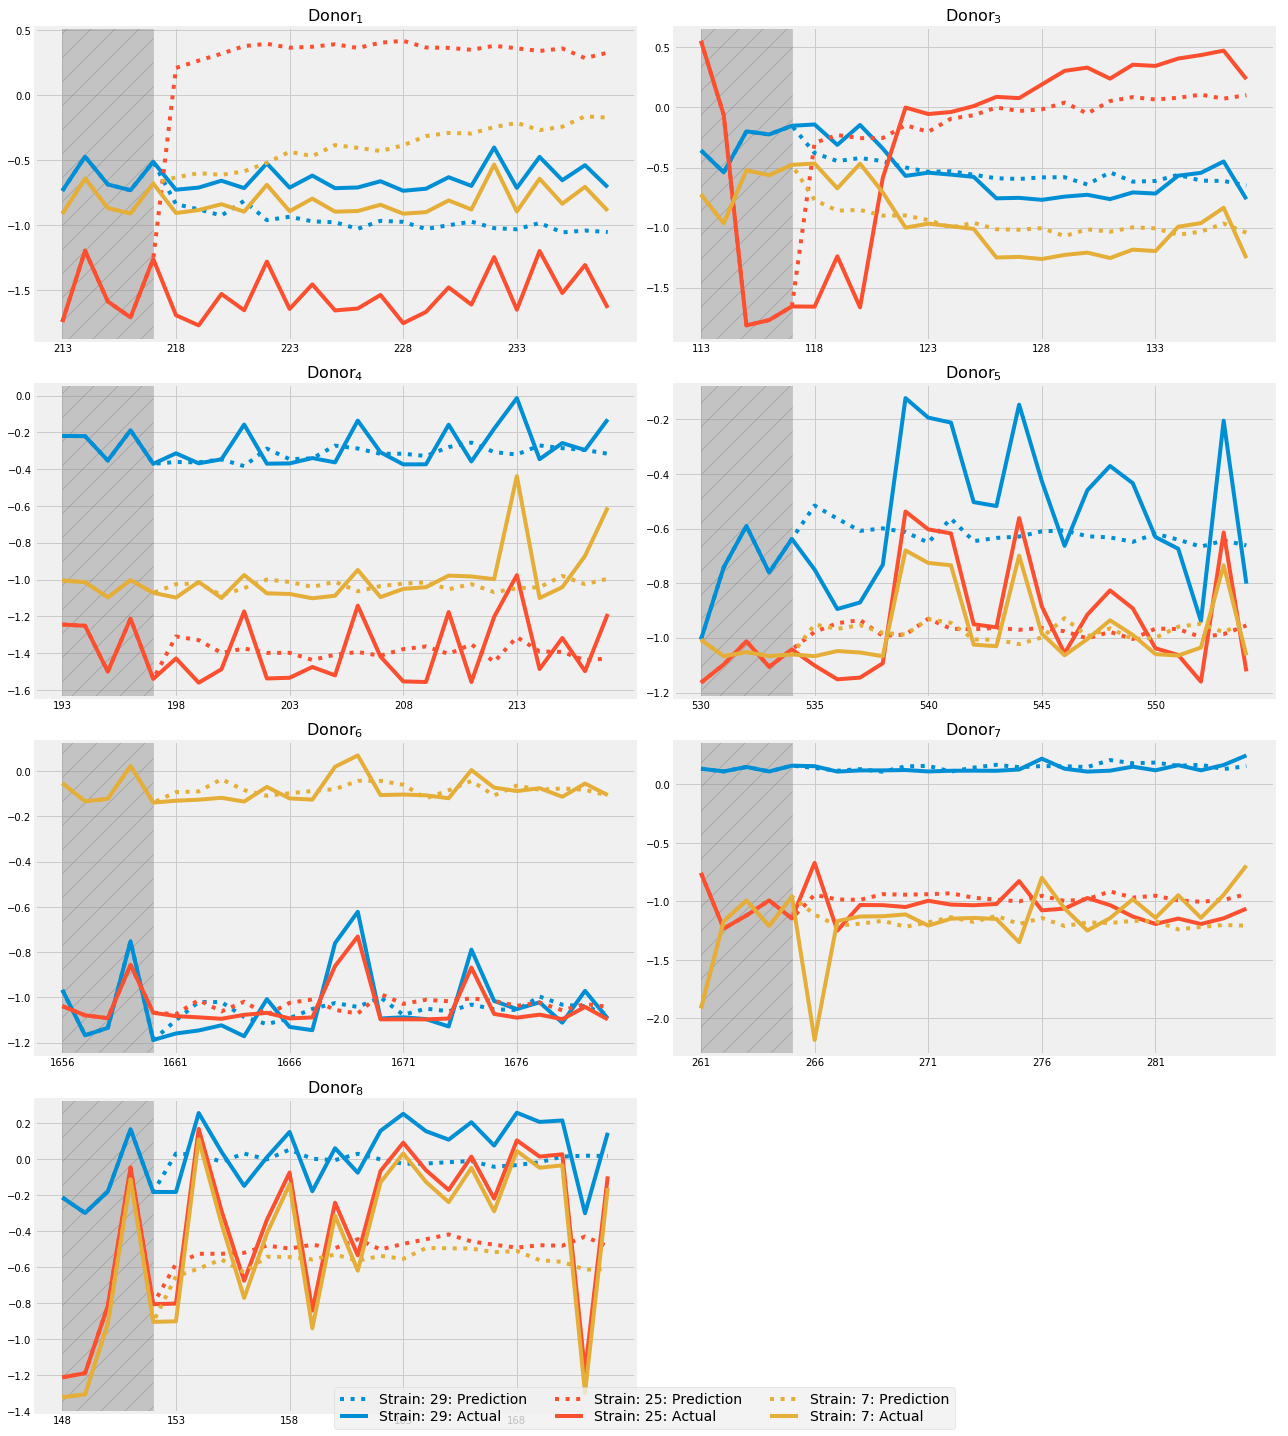

In [132]:
%matplotlib inline

# Generate subplots of the same data as above.
fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_width, subplot_height))
axl = ax.flatten()

k = 0
for i, s in enumerate(otu_handler.samples):
    if i in samps:
        start_index = int(starts[k] * s.shape[1])
        primer, comparison = get_primer_and_comparison_data(otu_handler, 
                                                            i, 
                                                            start_index, 
                                                            primer_len, 
                                                            predict_length)

        dream = model.daydream2(primer, predict_len=predict_length)

        if k == 0:
            for j, ri in enumerate(r):
                axl[k].plot(dream[ri, :, 0].T, ls=':', c=default_colors[j], label='{}: Prediction'.format(labels[j]))
                axl[k].plot(comparison[ri, :].T, c=default_colors[j], label='{}: Actual'.format(labels[j]))
        else:
            for j, ri in enumerate(r):
                axl[k].plot(dream[ri, :, 0].T, ls=':', c=default_colors[j], label='_nolegend_')
                axl[k].plot(comparison[ri, :].T, c=default_colors[j], label='_nolegend_')
        axl[k].axvspan(0, (primer_len) - 1, alpha=0.4, color='gray',
                    label='_nolegend_', hatch='/')
        axl[k].set_xticks(list(range(primer_len + predict_length))[::5])
        axl[k].set_xticklabels(list(range(start_index, start_index + primer_len + predict_length))[::5])
        axl[k].set_title(file_labs[i], fontsize=16)
        k += 1
# Cleanup
if num_rows * num_cols != len(samps):
    ax[-1, -1].axis('off')
plt.tight_layout() 
fig.legend(loc='lower center', ncol=len(r), labelspacing=0.2, fontsize=14)
# plt.suptitle('Model\'s Time-series Predictions', fontsize=24, y=0.9)
plt.show()
    

# Primer length effect on prediction accuracy

In [42]:
colors2 = [(0.031249343749343756, 1.0, 1.31250131249048e-06, 1.0),
 (0.5937486874986869, 0.0, 1.0, 1.0),
 (1.0, 0.0, 0.0, 1.0),
 (0.0, 0.718752625002625, 1.0, 1.0),
 (1.0, 0.0, 0.750000656250656, 1.0),
 (0.6874986874986876, 1.0, 0.0, 1.0),
 (1.0, 0.6562506562506562, 0.0, 1.0),
 (0.0, 0.062501968751969, 1.0, 1.0),
 (0.0, 1.0, 0.6249990812548694, 1.0)]

In [41]:
max_primer_len = 18
predict_length = 15
samps = [i for i, s in enumerate(otu_handler.samples) if s.shape[1] * 0.2 > max_primer_len + predict_length]
starts = [0.8] * len(otu_handler.samples)
primer_lens = list(range(2, max_primer_len))


primer_losses = np.zeros((len(primer_lens), len(otu_handler.samples)))
for i, s in enumerate(otu_handler.samples):
    if i in samps:
        start_index = int(starts[i] * s.shape[1])
        for j, p in enumerate(primer_lens):
            primer, comparison = get_primer_and_comparison_data(otu_handler, 
                                                                i, 
                                                                start_index, 
                                                                p, 
                                                                predict_length)
#             print(primer.shape)
            dream = model.daydream2(primer, predict_len=predict_length)
    #         print(primer.shape)
    #         print(dream.shape)
            mse = mean_squared_error(dream[:, p:, 0], 
                                     comparison[:, p:])
            primer_losses[j, i] = mse
        print('Done with a sample')


Done with a sample
Done with a sample
Done with a sample
Done with a sample
Done with a sample
Done with a sample


In [43]:
primer_losses = primer_losses[:, np.all(primer_losses != 0, axis=0)]

(16,)


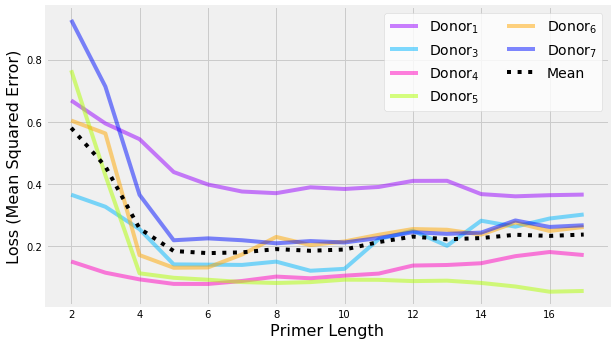

In [174]:
fig, ax = plt.subplots(figsize=(9, 5.5))
m = primer_losses.mean(axis=1)
print(m.shape)
for i in range(primer_losses.shape[1]):
    plt.plot(primer_losses[:, i], label=file_labs[samps[i]], alpha=0.5, c=colors2[samps[i]])
plt.plot(m, label='Mean', ls=':', c='black')
legend = plt.legend(frameon = 1, loc='upper right', fontsize=14, ncol=2)

frame = legend.get_frame()
frame.set_facecolor('white')
ax.set_xticks(list(range(len(primer_lens)))[::2])
ax.set_xticklabels(primer_lens[::2])
plt.xlabel('Primer Length', fontsize=16)
plt.ylabel('Loss (Mean Squared Error)', fontsize=16)
# plt.title('Increasing Primer Length\nDecreases Loss of Prediction', fontsize=24)
plt.show()

# Model Encoder PCA

In [163]:
in_weights = model.decoder_forward.linear[0].weight.cpu().detach().numpy()
out_weights = model.decoder_forward.linear[-1].weight.cpu().detach().numpy()
print(in_weights.shape, out_weights.shape)

(512, 512) (36, 512)


In [164]:
pca = PCA(n_components=2)
pca.fit(in_weights)
in_exp = pca.explained_variance_ratio_
in_fit = pca.transform(in_weights)

pca = PCA(n_components=2)
pca.fit(out_weights)
out_exp = pca.explained_variance_ratio_
out_fit = pca.transform(out_weights)
print(in_fit.shape, out_fit.shape)

(512, 2) (36, 2)


[0.02560737 0.01568373]


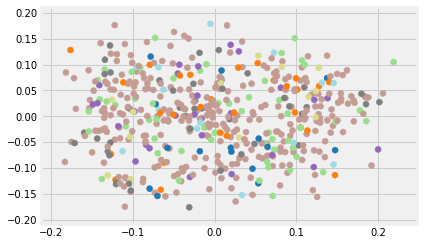

In [165]:
plt.scatter(in_fit[:, 0], in_fit[:, 1], c=colors_to_plot, cmap=cmap)
print(in_exp)

[0.04953887 0.04467633]


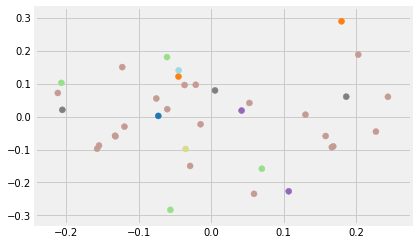

In [166]:
plt.scatter(out_fit[:, 0], out_fit[:, 1], c=colors_to_plot, cmap=cmap)
print(out_exp)